# Introduction to Wearable Data

Welcome to this introductory notebook on wearable data. This resource is designed to provide a comprehensive starting point for newcomers to the field. We begin by exploring "raw" data, such as accelerometer (ACC) and photoplethysmography (PPG) data, to gain insights into the underlying data sources of parameters provided by consumer-grade wearables. Additionally, we will exemplarily analyze Fitbit data to demonstrate data handling and processing techniques.


## Content
1. **Understanding "Raw" Data**
2. **Consumer Wearable Data**
3. **Useful Tools and Resources**

Each section builds on the previous ones, so it’s best to run this notebook cell by cell to ensure proper execution and understanding of the material.


<a id='understanding-raw-data'></a>
# Understanding "Raw" Data



Parameters derived from wearables are very diverse typical features include, steps, heart rate, sleep stages, activity levels (...) . These parameters typically are derived via algorithms from raw signals and might vary in accuracy depending on several factors including, user and vendor specificities, e.g. used algorithms to process the signals, built in sensors etc.

In order to better understand what happens "under the hood," we will use a dataset from a research-oriented device that provides access to raw accelerometer and PPG data. This dataset is particularly useful because it includes various labeled movements such as jumps, running, and handshakes, allowing us to highlight the challenges associated with measurements during movement. The dataset, an excerpt from the ScientISST MOVE project, was collected during natural everyday activities using wearable devices. Here, we will focus specifically on the accelerometer and PPG values from the Empatica E4 wristband. You can finde the complete dataset on [Physionet](https://physionet.org/content/scientisst-move-biosignals/1.0.1/)



## Installs

In [2]:
# Download data and install usefull packages
!rm -rf data
!curl -L "https://drive.usercontent.google.com/download?id=1BNuCJpBdG-nHitKsvLdLLpiPORvor90N&confirm=xxx" -o data.zip
!unzip data.zip && rm data.zip
!pip install neurokit2
!pip install pandas

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9096k  100 9096k    0     0   917k      0  0:00:09  0:00:09 --:--:-- 2484k
Archive:  data.zip
   creating: data/
  inflating: data/empatica_acc.csv   
  inflating: data/empatica_ppg.csv   
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Loading The Data

We start with loading the data using the pandas library [1]. This library provides several predefined functions for I/O of common datatypes used in wearables (see here for an overview). The data is stored in csv Format and Pandas provides predefined function to read .csv files (see ):

In [3]:
import pandas as pd

# We load the data with the pandas library
acc = pd.read_csv("./data/empatica_acc.csv", low_memory=False)
ppg = pd.read_csv("./data/empatica_ppg.csv", low_memory=False)

# Print the first two rows of the dataframe for overview
print(f'Dataframe acc:\n{acc.head(2)}\n.\n.\n.')
print(f'\nDataframe ppg:\n{ppg.head(2)}\n.\n.\n.')

Dataframe acc:
   unix_timestamp  acc_e4:z  acc_e4:x  acc_e4:y activities
0    9.466848e+08  0.573967 -0.226653  0.020438        NaN
1    9.466848e+08  1.189959 -0.444432  0.121458        NaN
.
.
.

Dataframe ppg:
   unix_timestamp  ppg:Left Wrist activities
0    9.466848e+08       -1.337061        NaN
1    9.466848e+08       -0.673702        NaN
.
.
.


As can be seen the dataframes contains the signals as columns, each row corresponds to one datapoint sampled at a given timestamp, each timepoint has a label asociated corresponding to a certain activity.

## Accelerometry

Let's visualize the 3-axis accelerometer data, where each axis represents acceleration recorded in a specific direction. You can explore and plot data for different activities by selecting the activity type in the cell on the right. 

**Note:** If you are running this notebook locally, you may need to manually set the variable `activity` to one of the commented parameters to view the corresponding data.


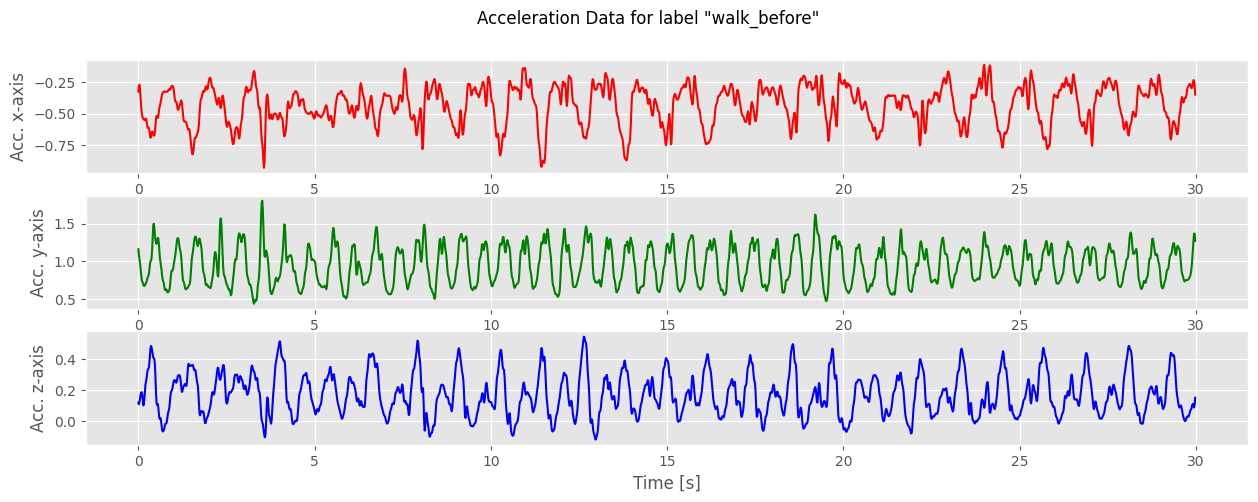

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')


# First we filter out the data labeled with activity
activity = 'walk_before' #@param ['lift-1','lift-2','greetings','jumps','gesticulate','walk_before_elevatordown','walk_before','run']
activity_acc = acc[acc['activities'] == activity].copy()

# Create a time vector for plotting based on the unix timestamps:
activity_acc['timestamp_seconds'] = activity_acc['unix_timestamp'] - activity_acc['unix_timestamp'].min()

# Plot 30seconds data for each axis
fig, ax = plt.subplots(3, 1, figsize=(15, 5))
activity_acc = activity_acc[activity_acc['timestamp_seconds'] < 30]
ax[0].plot(activity_acc['timestamp_seconds'], activity_acc['acc_e4:x'], label='X-axis', color='r')
ax[1].plot(activity_acc['timestamp_seconds'], activity_acc['acc_e4:y'], label='Y-axis', color='g')
ax[2].plot(activity_acc['timestamp_seconds'], activity_acc['acc_e4:z'], label='Z-axis', color='b')

# Add some labels
ax[0].set_ylabel('Acc. x-axis')
ax[1].set_ylabel('Acc. y-axis')
ax[2].set_ylabel('Acc. z-axis')
ax[2].set_xlabel('Time [s]')
fig.suptitle(f'Acceleration Data for label "{activity}"')
plt.show()

As can be seen from the actigraphy data, the actigraphy values are quite characteristic and are usually used to estimate patterns of physical activity and sleep. These include metrics like step count, activity intensity, and sleep quality.
The algorithms / methods used to derive this are usually proprietary. As such as already described above their accuracy is varying a lot between devices.

## Photoplethysmography

#### Simulated Data

Lets check out the PPG and see how heart rate is derived from it.
To give you an example of a prototypical PPG we can simulate one with the following lines of code:

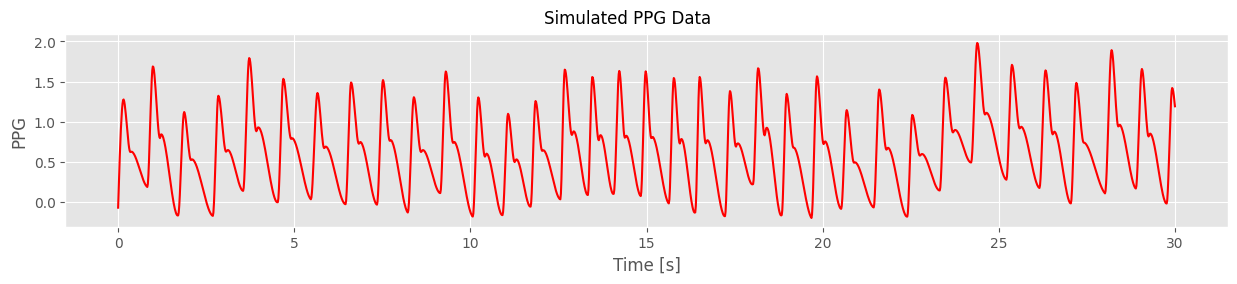

In [5]:
import neurokit2 as nk
import numpy as np

# Simulate 30s PPG data using neurokit2
ideal_ppg = nk.ppg_simulate(duration=30, sampling_rate=64, heart_rate=70)
seconds = np.linspace(0,30,64*30)

# Create the plot
fig = plt.figure(figsize=(15, 2.5))
plt.plot(seconds, ideal_ppg, label='X-axis', color='r')
plt.ylabel('PPG')
plt.xlabel('Time [s]')
fig.suptitle("Simulated PPG Data")
plt.show()

You can see a rapid upstroke during systole, representing the blood flow surge as the heart pumps, followed by a slower, gradual downstroke during diastole, with a distinct dicrotic notch caused by the closure of the aortic valve. This pattern repeats with each heartbeat. As such Heartrate (HR) or Heart Rate Variability (HRV) can be derived via Peakdetection algorithms. For example we can use the library neurokit to do this:

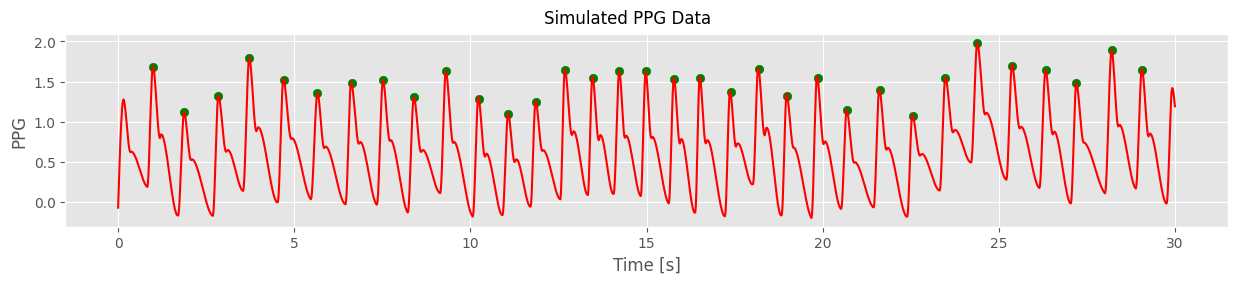

In [6]:
signals, info = nk.ppg_process(ideal_ppg, sampling_rate=64)

# Create the plot
fig = plt.figure(figsize=(15, 2.5))
plt.plot(seconds, ideal_ppg, label='X-axis', color='r')
plt.scatter(seconds[info["PPG_Peaks"]], ideal_ppg[info["PPG_Peaks"]], color='green')

# Add some labels
plt.ylabel('PPG')
plt.xlabel('Time [s]')
fig.suptitle("Simulated PPG Data")
plt.show()

HR and HRV can then be calculated using the interval between successive peaks, the so called Inter-Beat Intervals (IBIs). Heart Rate (HR) is simply the inverse of the time difference between consecutive peaks, typically expressed in beats per minute (BPM) and is typically estimated using:

$HR = \frac{60}{IBI}$.

HRV, on the other hand, is a measure of the variation in time between consecutive IBIs. Various time-domain methods (e.g., standard deviation of IBIs, RMSSD) and frequency-domain methods (e.g., power spectral density) can be used to quantify HRV, providing insights into autonomic nervous system activity.
High HRV is e.g. linked to better cardiovascular health and resilience, while low HRV is associated with stress.

**Further Information**

- [Billman GE, Huikuri HV, Sacha J and Trimmel K (2015) An introduction to heart rate variability: methodological considerations and clinical applications. Front. Physiol. 6:55. doi: 10.3389/fphys.2015.00055](https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2015.00055/full)

- [Billman GE (2011) Heart rate variability – a historical perspective. Front. Physio. 2:86. doi: 10.3389/fphys.2011.00086](https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2011.00086/full)

#### Real-World data

Let’s plot the real-world PPG data. You can explore and visualize different activities or conditions by selecting the type of activity you want to plot on the right side of the following cell.


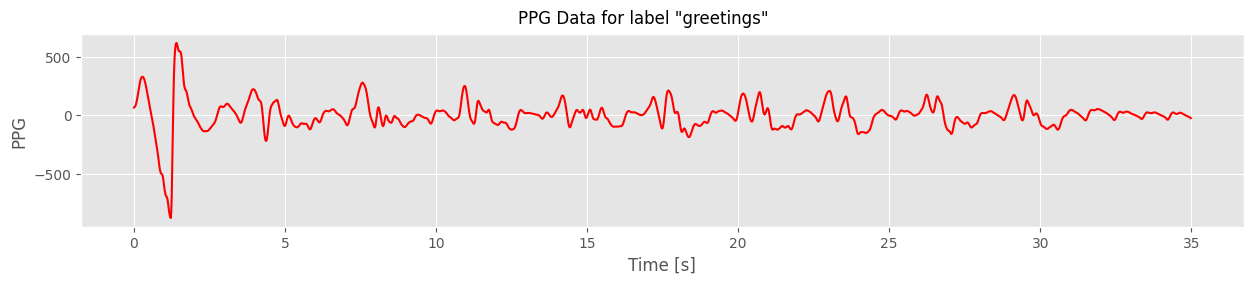

In [7]:
# First we filter out the data labeled with 'greetings' activity
activity = 'greetings' #@param ['lift-1','lift-2','greetings','jumps','gesticulate','walk_before_elevatordown','walk_before','run']
activity_ppg = ppg[ppg['activities'] == activity].copy()

# Lets create a time vector for plotting based on the unix timestamps:
activity_ppg['timestamp_seconds'] = activity_ppg['unix_timestamp'] - activity_ppg['unix_timestamp'].min()

# Plot 30seconds data for each axis
fig = plt.figure(figsize=(15, 2.5))
activity_ppg = activity_ppg[activity_ppg['timestamp_seconds'] < 35]
plt.plot(activity_ppg['timestamp_seconds'], activity_ppg['ppg:Left Wrist'], label='X-axis', color='r')

# Add some labels
plt.ylabel('PPG')
plt.xlabel('Time [s]')
fig.suptitle(f'PPG Data for label "{activity}"')
plt.show()


The shape of the PPG signal is pretty different from our simulated signal, and for different activities, the shape looks quite different and noisy. For example, we can clearly identify the actigraphy patterns from our greetings example above.

So, a lot of advanced signal processing magic has to happen to actually get valid HR measurements from the signals. Typical consumer devices use proprietary algorithms to process raw signals and derive meaningful parameters such as heart rate. These algorithms are often optimized for specific use cases and sensor configurations, which can lead to significant variations in accuracy between different vendors.

If you are interested in reading more about this topic:

Further Information on this:

- [Nelson, B. W. & Allen, N. B. Accuracy of consumer wearable heart rate measurement during an ecologically valid 24-hour period: intraindividual validation study. *JMIR mHealth uHealth* 7, e10828 (2019).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6431828/)

- [Etiwy, M. et al. Accuracy of wearable heart rate monitors in cardiac rehabilitation. *Cardiovasc. Diagn. Ther.* 9, 262–271 (2019).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6603497/)

- [Rob ter Horst systematically tests on smartwatches and health trackers on his youtube channel](https://www.youtube.com/channel/UChNWxrTlmh4IRSevon1X93g)




<a id='consumer-wearable-data'></a>
# Consumer wearable data

Before we start, here are a few notes on data access and data importing. As diverse as manufacturers for wearable devices are, so too are the data access schemes and the possibilities for extracting data from (cloud-based) platforms. Some vendors offer manual downloads via their platforms, while others provide advanced APIs for fetching data. For some, third-party apps like Strava must be used. There is a great project by the Snyder Lab at Stanford University showcasing API data access for various devices: [Wearipedia Homepage](http://wearipedia.com/), [Wearipedia on GitHub](https://github.com/Stanford-Health/wearipedia).

However, as a Data Scientist/Analyst, the data is often already fetched and handed over in various formats. Below are a few relevant formats in the area of wearable data, along with Python tools that can be used to load and process them:

Data Formats and Python Tools

| **Data Format** | **Device/Platform**         | **Python Tool**                                                                 | **Description**                                                                                   |
|-----------------|-----------------------------|---------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **.fit**        | Garmin, Strava, Zwift        | [`fitparse`](https://github.com/dtcooper/python-fitparse) | Library to parse `.fit` files, which are specific to Garmin and some fitness platforms.          |
| **.gpx**        | Various GPS devices          | [`gpxpy`](https://github.com/tkrajina/gpxpy), [`geopandas`](https://geopandas.org)             | An XML-based format used to store GPS data, like routes and tracks, commonly used by GPS devices.  |
| **.tcx**        | Garmin, Strava               | [`lxml`](https://lxml.de/), [`pandas`](https://pandas.pydata.org)                                | An XML-based format primarily used for fitness data such as heart rate, distance, and workout info.|
| **.csv**        | Fitbit, Apple Health, Others | [`pandas`](https://pandas.pydata.org)                                                             | CSV files are simple, tabular formats commonly used for exporting wearable data.                   |
| **.json**       | Fitbit, Whoop, Oura          | [`pandas`](https://pandas.pydata.org), [`json`](https://docs.python.org/3/library/json.html)      | JSON is often used by cloud platforms to structure complex data, which can be easily processed in Python. |
| **.xml**        | Polar, Garmin, Other         | [`lxml`](https://lxml.de/), [`xml.etree.ElementTree`](https://docs.python.org/3/library/xml.etree.elementtree.html)   | Generic XML format for data exports. Often used as a container for various structured data formats.|




You have already seen how easy it is to read .csv files using `pandas`. In the following example, we will work with .json files. The dataset we are using is an excerpt from the LifeSnaps dataset, which includes Fitbit Sense smartwatch data capturing physical activity, sleep patterns, and stress levels collected over four months from 71 participants. You can find the complete dataset on [Kaggle](https://www.kaggle.com/datasets/skywescar/lifesnaps-fitbit-dataset) and [Zenodo](https://zenodo.org/records/7229547).


## Installs

In [8]:
!rm -f fitbit_data.json
!curl -L "https://drive.usercontent.google.com/download?id=18_LunsS6m4GM6j_w3d7qBNGf8y-6-FVg&confirm=xxx" -o fitbit_data.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  10.0M      0  0:00:19  0:00:19 --:--:-- 11.2M


## Loading the data

Let's import and inspect the data (this might take a few seconds):

In [9]:
import pandas as pd

fitbit_data = pd.read_json('fitbit_data.json', lines=True)

In [10]:
# Inspect the types of data present
fitbit_data['type'].unique()

array(['estimated_oxygen_variation', 'Profile', 'altitude', 'calories',
       'demographic_vo2_max', 'distance', 'exercise', 'heart_rate',
       'lightly_active_minutes', 'moderately_active_minutes',
       'resting_heart_rate', 'sedentary_minutes', 'steps',
       'time_in_heart_rate_zones', 'very_active_minutes',
       'Computed Temperature', 'Daily Heart Rate Variability Summary',
       'Heart Rate Variability Details',
       'Heart Rate Variability Histogram', 'Respiratory Rate Summary',
       'sleep', 'Wrist Temperature', 'badge', 'Stress Score'],
      dtype=object)

The dataset encompasses a variety of recorded data types, reflecting different aspects of health and activity. Note that the specific data presented may vary depending on the wearable device used. For the following analysis, we will focus on heart rate and steps.




### Heartrate

#### Select the Data of Interest

In [11]:
# Filter out the heartrate data
hr = fitbit_data[fitbit_data['type'] == 'heart_rate']
hr.head()

,_id,id,type,data
188209,{'$oid': '62cc1fb7b41dcd4b1bf0e2a9'},{'$oid': '621e2e8e67b776a24055b564'},heart_rate,"{'dateTime': '2021-05-24T00:00:01', 'value': {..."
188210,{'$oid': '62cc1fb7b41dcd4b1bf0e2ac'},{'$oid': '621e2e8e67b776a24055b564'},heart_rate,"{'dateTime': '2021-05-24T00:00:16', 'value': {..."
188211,{'$oid': '62cc1fb7b41dcd4b1bf0e2af'},{'$oid': '621e2e8e67b776a24055b564'},heart_rate,"{'dateTime': '2021-05-24T00:00:31', 'value': {..."
188212,{'$oid': '62cc1fb7b41dcd4b1bf0e2b2'},{'$oid': '621e2e8e67b776a24055b564'},heart_rate,"{'dateTime': '2021-05-24T00:00:46', 'value': {..."
188213,{'$oid': '62cc1fb7b41dcd4b1bf0e2b5'},{'$oid': '621e2e8e67b776a24055b564'},heart_rate,"{'dateTime': '2021-05-24T00:01:06', 'value': {..."


We see that the Dataframe is still nested. This is quite common for nested .json files. So as a first step we want to flatten this:

In [12]:
hr = pd.json_normalize(hr['data'])
hr.head()

,dateTime,value.bpm,value.confidence
0,2021-05-24T00:00:01,67,1
1,2021-05-24T00:00:16,71,1
2,2021-05-24T00:00:31,70,1
3,2021-05-24T00:00:46,69,2
4,2021-05-24T00:01:06,69,1


Let's check if everything is in the right format

In [13]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833645 entries, 0 to 833644
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   dateTime          833645 non-null  object
 1   value.bpm         833645 non-null  int64 
 2   value.confidence  833645 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 19.1+ MB


The column dateTime is represented as "object". However in order to use pandas advanced dateTime processing we need to convert it:

In [14]:
hr['dateTime'] = pd.to_datetime(hr['dateTime'])
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833645 entries, 0 to 833644
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   dateTime          833645 non-null  datetime64[ns]
 1   value.bpm         833645 non-null  int64         
 2   value.confidence  833645 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 19.1 MB


Now all data types are as desired, with integer values for heart rate measures and datetime format for the date and time column.

#### Exploratory Data Analysis

In consumer wearables, it is common for the sampling rate to be non-uniform due to factors such as sensors being turned on or off during activities, the device not being worn continuously, or power-saving measures. We can verify this variability as follows:


In [15]:
# First we sort the date times in ascending order
hr.sort_values(by='dateTime', inplace=True)

# Then we calculate some stats on the difference of consecutive timestamps
hr['dateTime'].diff().describe()

count                       833644
mean     0 days 00:00:07.151248014
std      0 days 00:00:53.941775908
min                0 days 00:00:01
25%                0 days 00:00:05
50%                0 days 00:00:05
75%                0 days 00:00:10
max                0 days 06:54:17
Name: dateTime, dtype: object

We can see that the sampling rate varies significantly, with a median duration of 5 seconds and a wide range extending up to nearly 7 hours.

Lets have have a look at data recorded at one day. For this we extract the data at one day and plot it

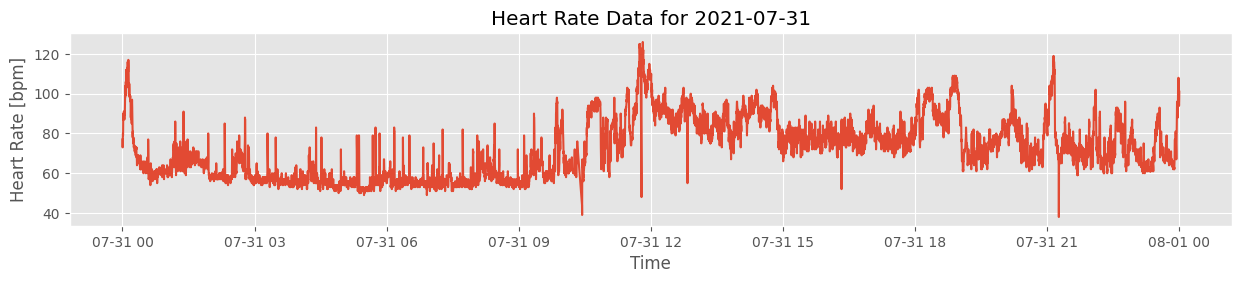

In [16]:
# Extract data at one day
hr_day = hr[hr['dateTime'].dt.date == pd.to_datetime('2021-07-31').date()]

# Plot figure
plt.figure(figsize=(15,2.5))
plt.plot(hr_day['dateTime'], hr_day['value.bpm'])
plt.xlabel("Time")
plt.ylabel("Heart Rate [bpm]")
plt.title("Heart Rate Data for 2021-07-31")
plt.show()

#### Preprocessing

We see that heart rate values exhibit considerable scatter with occasional sudden peaks. Fitbit assigns a “confidence level” to each heart rate measurement, with scores of 0, 1, or 3. A score of 3 signifies high reliability, 1 indicates moderate reliability, and 0 reflects low reliability due to a weak optical signal. Let’s examine these scores and visualize the measurements with the lowest confidence levels.

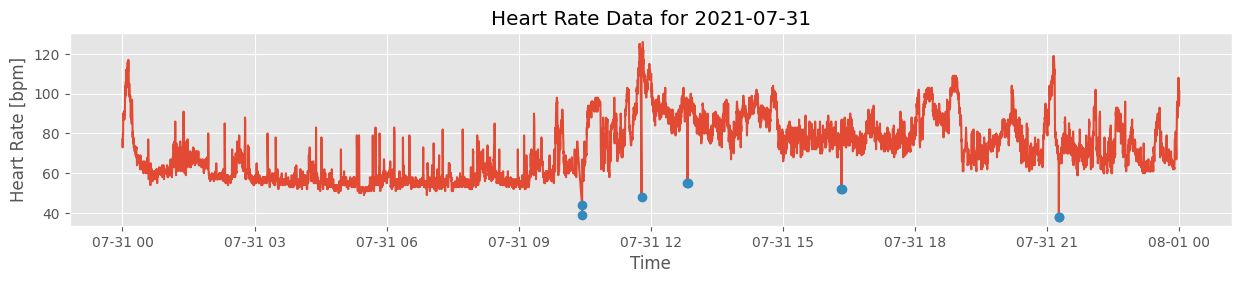

In [17]:
# Filter out values with 0 confidence
hr_day_filt = hr_day[hr_day['value.confidence'] == 0]

# Plot
plt.figure(figsize=(15,2.5))
plt.plot(hr_day['dateTime'], hr_day['value.bpm'])
plt.plot(hr_day_filt['dateTime'], hr_day_filt['value.bpm'], 'o', label='low confidence')
plt.xlabel("Time")
plt.ylabel("Heart Rate [bpm]")
plt.title("Heart Rate Data for 2021-07-31")
plt.show()

To effectively manage and analyze our data, especially when merging datasets or addressing inaccuracies, resampling can be very useful. Resampling involves aggregating data over specified time intervals, which can help in smoothing out noise and reducing the impact of erroneous data points.

With Pandas, resampling is straightforward. We can take the average (or apply other aggregation functions) over chosen time periods to create a more manageable and accurate dataset.

In [18]:
hr_day = hr_day.set_index('dateTime')

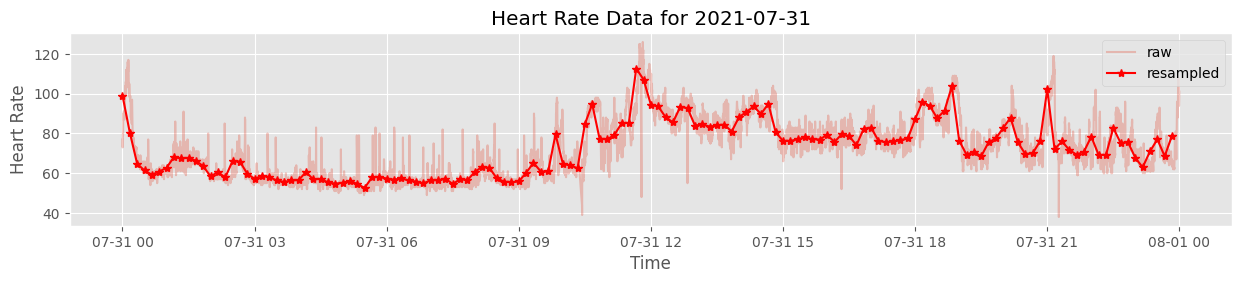

In [19]:
hr_day_resamp = hr_day.resample('10min').mean()
plt.figure(figsize=(15,2.5))
plt.plot(hr_day.index, hr_day['value.bpm'],label='raw', alpha=.3)
plt.plot(hr_day_resamp.index, hr_day_resamp['value.bpm'],'*-', label='resampled', color='r')
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Heart Rate Data for 2021-07-31")
plt.legend()
plt.show()

As you can see, this flattens the signal and we get rid of the sudden peaks. However, resampling also has drawbacks. It can lead to a loss of detail and granularity, as the process involves aggregating data points into broader time intervals. This can obscure short-term variations and potentially mask important trends or anomalies. Additionally, choosing inappropriate resampling intervals might introduce bias or distort the true representation of the data.

#### Descriptives

Finally we can calculate some stats for this day

In [20]:
hr_day_resamp.describe()

,value.bpm,value.confidence
count,144.000000,144.000000
mean,72.217211,1.858728
std,13.481483,0.762730
min,52.625000,0.986842
25%,59.644834,1.113815
50%,70.929565,1.566861
75%,80.662563,2.720884
max,112.644737,2.986301


### Steps

Handling of the step data is similar to the handling of the heart rate values

#### Data loading

In [21]:
# Get the data
steps = fitbit_data[fitbit_data['type'] == 'steps']
steps = pd.json_normalize(steps['data'])

In [22]:
# Check data formats
steps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45596 entries, 0 to 45595
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dateTime  45596 non-null  object
 1   value     45596 non-null  object
dtypes: object(2)
memory usage: 712.6+ KB


In [23]:
# Change formats if neccesary
steps['dateTime'] = pd.to_datetime(steps['dateTime'])
steps['value'] = steps['value'].astype(int)
steps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45596 entries, 0 to 45595
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateTime  45596 non-null  datetime64[ns]
 1   value     45596 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 712.6 KB


#### Exploratory Data Analysis

Check out the sampling rate range of the step counts

In [24]:
steps['dateTime'] = pd.to_datetime(steps['dateTime'])
steps.sort_values(by='dateTime', inplace=True)
steps['dateTime'].diff().describe()

count                        45595
mean     0 days 00:02:12.328983441
std      0 days 00:06:13.971106386
min                0 days 00:01:00
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:01:00
max                0 days 06:54:00
Name: dateTime, dtype: object

At best, we have step counts recorded every few minutes. However, the mean interval is just over 2 minutes, with most data points spaced 1 minute apart. Despite this, there are some irregular intervals, with gaps reaching up to nearly 7 hours.

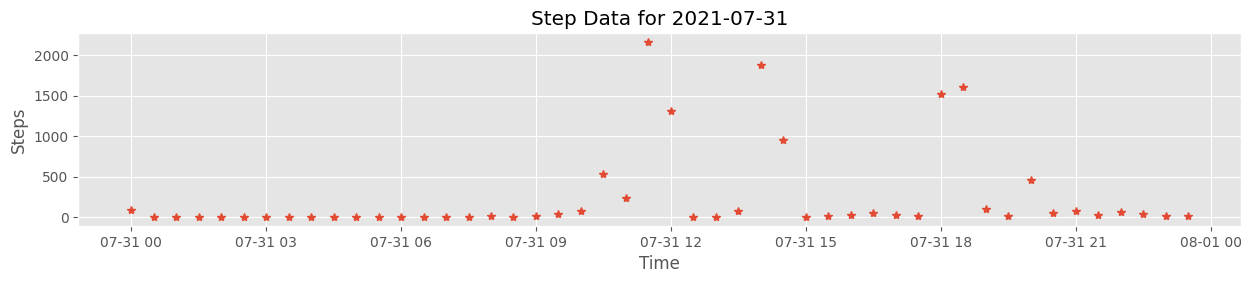

In [27]:
# Filter data for one day
steps_day = steps[steps['dateTime'].dt.date == pd.to_datetime('2021-07-31').date()]
steps_day  = steps_day.set_index('dateTime')

# Calculate hourly steps
steps_day_resamp = steps_day.resample('30Min').sum()

# Plot
plt.figure(figsize=(15,2.5))
plt.plot(steps_day_resamp.index, steps_day_resamp['value'],'*')
plt.xlabel("Time")
plt.ylabel("Steps")
plt.title("Step Data for 2021-07-31")
plt.show()


#### Descriptives

In [29]:
print(f'Total steps: {steps_day["value"].sum()}')
print(f'Max steps: {steps_day["value"].max()} at {steps_day["value"].idxmax()}')

Total steps: 11435
Max steps: 119 at 2021-07-31 11:44:00


## Useful Tools and Resources

Some tools we didn't cover here are especially useful for feature extraction and machine learning:

- **`tslearn`**: A machine learning library specifically designed for time series data. It provides tools for preprocessing, clustering, classification, and regression of time series data. [tslearn Documentation](https://tslearn.readthedocs.io/en/stable/)

- **`tsfresh`**: A powerful library for time series feature extraction. It automatically extracts a large number of features from time series data and is useful for feature engineering and model improvement. [tsfresh Documentation](https://tsfresh.readthedocs.io/en/latest/)

- **`tsfel`**: A library for time series feature extraction and labeling. It offers a comprehensive set of tools for extracting features from time series data and is valuable for both exploratory analysis and predictive modeling. [tsfel Documentation](https://tsfel.readthedocs.io/en/latest/)

For basic usage and examples, check out the linked resources.


